In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import pandas as pd 
import requests as res

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", palette="dark")

In [3]:
from imblearn.over_sampling import RandomOverSampler

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Art Garfunkel's Favorite Books

The dataset I am using to day is [Art Garfunkels's Library](https://www.kaggle.com/datasets/chrico03/art-garfunkels-library). Art Garfunkel is an American singer best known for his hit act with Paul Simon - Simon & Garfunkel. Ever since the 1970s, he has been recording the books he collects and reads over the years on his website. I will be using the prepared dataset of his "[Library](https://www.artgarfunkel.com/)" to try and predict which of the 1000+ books in his library are likely to be his favorite.

In [4]:
df = pd.read_csv("/kaggle/input/art-garfunkels-library/Art Garfunkel Library.csv")
df.head()

,Date Read,Author,Books,Year Published,Pages,Favorite
0,Jun-68,Jean-Jacques Rousseau,The Confessions,1781,606,1
1,Jun-68,Erich Fromm,The Art of Loving,1956,146,1
2,Jun-68,Mark Twain,The Adventures of Huckleberry Finn,1884,288,0
3,Jul-68,James Thurber,My Life and Hard Times,1933,115,0
4,Jul-68,William Shakespeare,Romeo and Juliet,1596,146,0


## Data Exploration & Cleaning
First, I will get the data into a format which I find more usable for my purposes.
- The 'Date Read' column can be broken up into two separate columns - 'Month Read' and 'Year Read'.
- The 'Year Published" column has a wide range of dates, some of which may be difficult to process (ie. "10,000 B.C."). Python is not great at handling these kinds of dates well, even using the datetime module. You can read more about it [here](https://realpython.com/lessons/messy-date-time/#transcript). So I will be removing these 45 rows.



In [5]:
months = dict(Jan=1,Feb=2,Mar=3,Apr=4,May=5,Jun=6,Jul=7,Aug=8,Sep=9,Oct=10,Nov=11,Dec=12)

# Separates 'date' and 'month' read into separate columns
def get_month_from_date_read_column(date, to_numeric=True):
    month_date_split = date.split('-')
    
    if len(month_date_split) == 2:
        if to_numeric == True:
            return int(months[month_date_split[0]])
        else:
            return month_date_split[0]
    else:
        return np.nan
    
def get_year_from_date_read_column(date):
    year_date_split = date.split('-')
    if len(year_date_split) == 2:
        year = int(year_date_split[1])
        if year < 41: # FUN FACT: Art's Year of Birth: 1941
            return int(2000+year)
        else :
            return int(1900+year)
    else:
        return date

In [6]:
# Removing the 'Year Published' columns for older dates not easily converted to int64
bce, indexes_to_drop = [],[]
library_df = df.copy()

for idx in df.index:
    year = df.iloc[idx]['Year Published']
    if len(year) != 4 or str(year[-1]).isalpha():
        indexes_to_drop.append(idx)
        bce.append(year)
library_df.drop(indexes_to_drop, inplace = True) 

print("Number of non-standard dates for year published:", len(bce))
print("New size of dataset:", len(library_df))

Number of non-standard dates for year published: 52
New size of dataset: 1269


In [7]:
library_df['Cat_Month Read'] = library_df['Date Read'].apply(lambda date: get_month_from_date_read_column(date,False))
library_df['Month Read'] = library_df['Date Read'].apply(lambda date: get_month_from_date_read_column(date))

library_df['Year Read'] = library_df['Date Read'].apply(lambda date: str(get_year_from_date_read_column(date))).astype('int')
library_df['Year Published'] = pd.to_numeric(library_df['Year Published'])

## Exploratory Analysis
Now we can look at the data to determine which features can be used for the analysis. I decided not to use 'Author' or 'Books' because of thier high number of unique entries relative to the total size of the dataset. The other columns can be encoded as labels that have more significant relevance to the rest of items in it.

In [8]:
library_df.describe(percentiles=[])

,Year Published,Pages,Favorite,Month Read,Year Read
count,1269.000000,1269.000000,1269.000000,1144.000000,1269.000000
mean,1929.412924,314.870764,0.101655,6.716783,1995.133964
std,103.580458,191.937705,0.302313,3.470944,13.585319
min,1180.000000,13.000000,0.000000,1.000000,1968.000000
50%,1965.000000,275.000000,0.000000,7.000000,1994.000000
max,2021.000000,1664.000000,1.000000,12.000000,2022.000000


In [9]:
library_df.describe(include='object')

,Date Read,Author,Books,Cat_Month Read
count,1269,1269,1269,1144
unique,490,929,1254,12
top,2008,William Shakespeare,The Confessions,Dec
freq,34,15,3,117


Here, we can look at the target feature. The target column for this dataset is 'Favorite'; there's a big imbalance between the number of non-favorite vs. favorite books, which affects how we will approach our analysis.

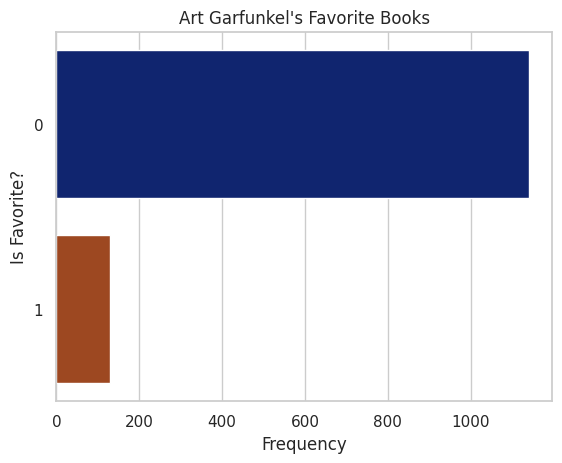

In [10]:
sns.countplot(y=library_df['Favorite'],data=library_df)
plt.title("Art Garfunkel's Favorite Books")
plt.xlabel("Frequency")
plt.ylabel("Is Favorite?")
plt.show()

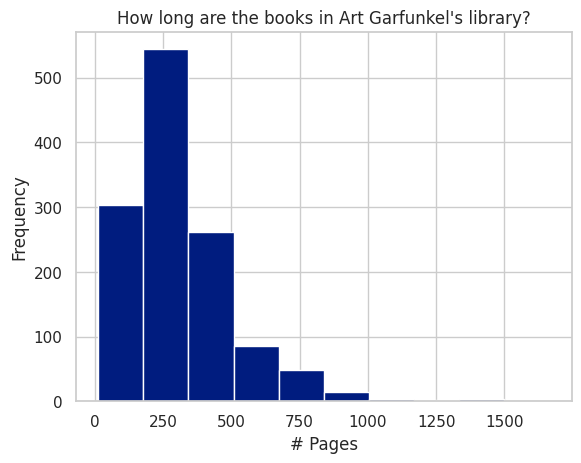

In [11]:
library_df['Pages'].hist()

plt.title("How long are the books in Art Garfunkel's library?")
plt.xlabel("# Pages")
plt.ylabel("Frequency")
plt.show()

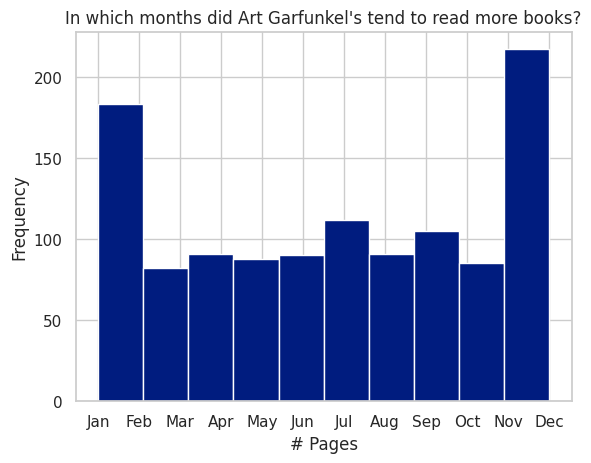

In [12]:
month_frequency = library_df['Cat_Month Read'].dropna().tolist()
month_frequency.sort(key=lambda m: months[m])
pd.Series(month_frequency).hist()

plt.title("In which months did Art Garfunkel's tend to read more books?")
plt.xlabel("# Pages")
plt.ylabel("Frequency")

plt.show()

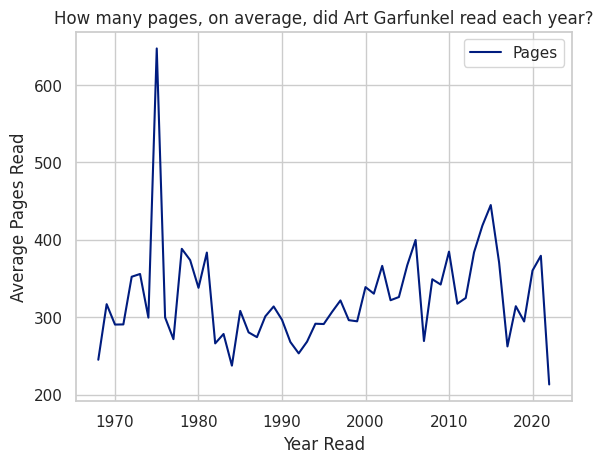

In [13]:
library_df["Year Read"] = library_df["Year Read"].astype(int)
pages_per_year = library_df[['Year Read', 'Pages']].groupby(['Year Read']).mean()

sns.lineplot(pages_per_year)

plt.title("How many pages, on average, did Art Garfunkel read each year?")
plt.xlabel("Year Read")
plt.ylabel("Average Pages Read")
plt.show()

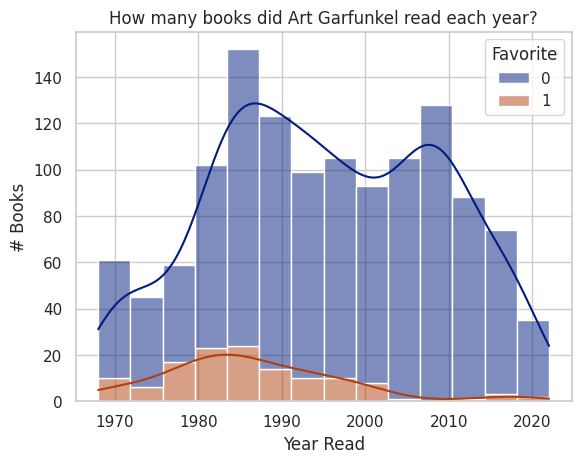

In [14]:
sns.histplot(data=library_df, x="Year Read", hue='Favorite', kde=True, multiple='stack')

plt.title("How many books did Art Garfunkel read each year?")
plt.xlabel("Year Read")
plt.ylabel("# Books")
plt.show()

* I will use RobustScaler for the data as there are a few outliers across the columns found during data exploration.
* 'Month Read' will also be encoded cyclically so the seuqential nature of the month category will be taken into account within the model.

## Model Creation

In [15]:
# Encoding cyclical features (hour, month, year, etc.)
library_df['cos_Month Read'] = np.sin(2 * np.pi * library_df['Month Read']/12.0)
library_df['sin_Month Read'] = np.sin(2 * np.pi * library_df['Month Read']/12.0)
library_df.drop(columns=["Month Read"], inplace=True)

In [16]:
transformer = make_column_transformer(
    (RobustScaler(), ['Year Read', 'Year Published', 'Pages']),
    remainder="passthrough")

transformed = transformer.fit_transform(library_df)
feature_names = [name.split("__")[-1] for name in transformer.get_feature_names_out()]
print("Number of features: ", len(feature_names) , "\n", feature_names)

Number of features:  10 
 ['Year Read', 'Year Published', 'Pages', 'Date Read', 'Author', 'Books', 'Favorite', 'Cat_Month Read', 'cos_Month Read', 'sin_Month Read']


In [17]:
transformed_df = pd.DataFrame(transformed, columns=feature_names).dropna()
transformed_df = transformed_df.drop(columns=['Author', 'Books', 'Date Read', 'Cat_Month Read'])

x = transformed_df.drop(columns=['Favorite'])
y = transformed_df['Favorite'].astype('int').to_frame()

Since our classes are imbalanced, accuracy may not be the best performance metric. So, instead, we will be using the F-1 score as our evaluation metric, which allows us to produce more reliable results for an imbalanced dataset such as this.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.05,random_state=42)
print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))

c_params = [0.001, 0.01, 0.05, 0.1, 1.0, 100.0, 1000.0]
clf = LogisticRegressionCV(random_state=42,
                           scoring='f1',
                           multi_class='ovr',
                           Cs=c_params)
clf.fit(x_train,y_train)

print("\nF-1 score: ", clf.score(x_test,y_test))

y_pred = clf.predict(x_test)
print("\nClassification Report\n",classification_report(y_test, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_test,y_pred))

x_train shape: (1086, 5)
x_test shape: (58, 5)

F-1 score:  0.25

Classification Report
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        51
           1       1.00      0.14      0.25         7

    accuracy                           0.90        58
   macro avg       0.95      0.57      0.60        58
weighted avg       0.91      0.90      0.86        58

Confusion Matrix
 [[51  0]
 [ 6  1]]


## Model Evaluation

The accuracy is very high, but the other metrics are not great. I will attempt again with overfitting, which will decrease the current accuracy score, but the overfitted data will produce metrics with resampled data that predict both classes more often.

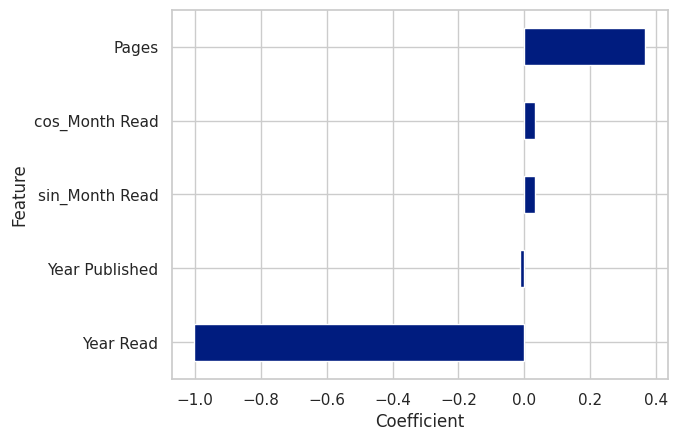

In [19]:
coefs = pd.Series(clf.coef_.ravel(), index=clf.feature_names_in_)
coefs.sort_values().plot(kind='barh')

plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

In [20]:
oversampler = RandomOverSampler(random_state=42)
X,Y = oversampler.fit_resample(x,y)
print("Resampled data new shape: ", X.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,random_state=42,stratify=Y)
print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))

c_params = [0.001, 0.01, 0.05, 0.1, 1.0, 100.0, 1000.0]

clf = LogisticRegressionCV(solver='liblinear',
                           random_state=42,
                           scoring='f1',
                           multi_class='ovr',Cs=c_params)
clf.fit(x_train,y_train)

print("\nF-1 score: ", clf.score(x_test,y_test))

y_pred = clf.predict(x_test)

print("\nClassification Report\n",classification_report(y_test, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_test,y_pred))

Resampled data new shape:  (2038, 5)
x_train shape: (1528, 5)
x_test shape: (510, 5)

F-1 score:  0.7272727272727273

Classification Report
               precision    recall  f1-score   support

           0       0.76      0.57      0.65       255
           1       0.66      0.82      0.73       255

    accuracy                           0.69       510
   macro avg       0.71      0.69      0.69       510
weighted avg       0.71      0.69      0.69       510

Confusion Matrix
 [[146 109]
 [ 47 208]]


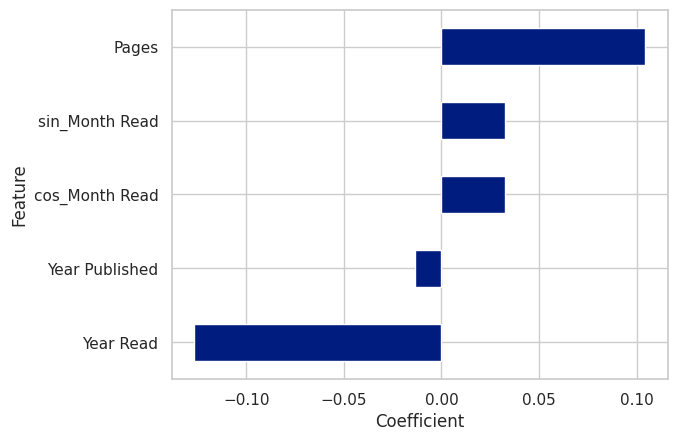

In [21]:
coefs = pd.Series(clf.coef_.ravel(), index=clf.feature_names_in_)
coefs.sort_values().plot(kind='barh')

plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

## Final Thoughts
When doing this analysis, I tested several models type, feature encodings and model parameters. Perhaps the results may improve with different options, I chose what I believed went best for the question I was trying to answer. So when I run the analysis again, both classes are predicted more often and our score has decreased, but with the more balanced classes, the estimate obtained here we know is using more data to predict both classes. The coefficients changed in number, but not relative to one another. 

Perhaps, in the future, I could improve my results if I:
* Find a way to increase the sample size - either by finding new ways to process dropped rows so they can remain within the dataset for the analysis
* Perform data scraping on Art Garfunkel's website to update the initial dataset to include any more recent entries.
* Encode the year and month data in different ways such as using binning to reduce dimensionality. For example, encoding 'Month Read' as categorical labels within bins I define as 3-month-long 'Seasons.'

